## This will use the Gaussian kernel reconstruction method in the Roberts JEI paper

Code uses Python version 3.86

Gaussian kernel reconstruction code used is published in:
Roberts, J. L., Tozer, C. R., Ho, M., Kiem, A. S., Vance, T. R., Jong, L. M., … van Ommen, T. D. (2019). Reconciling Unevenly Sampled Paleoclimate Proxies: a Gaussian Kernel Correlation Multiproxy Reconstruction. Journal of Environmental Informatics, 1–15. https://doi.org/10.3808/jei.201900420

Python libraries are used, with Fortran linearisation tool included with the above code to linearise the proxies.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pandas import DataFrame
from scipy.stats import pearsonr

import os
import tempfile
import datetime
import subprocess
import shutil


In [3]:
import sys
sys.version

'3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 05:05:16) \n[GCC 9.3.0]'

In [4]:
#rewrite this to use the new dataset with only 1 file

ipo_index=np.loadtxt('data/IPO_av_from_monthly2020.csv',delimiter=",",skiprows=1)[:,1] #1872-2017
ipo_years=np.loadtxt('data/IPO_av_from_monthly2020.csv',delimiter=",",skiprows=1)[:,0]

#LD_data=np.flipud(np.genfromtxt('../data/LD_logCl_IPOrecon2027y_Sept2020.csv',delimiter=",",skip_header=2))
LD_data=np.flipud(np.genfromtxt('data/DSS_2k_winter_centred.csv',delimiter=",",skip_header=1))
smooth_ipo=gaussian_filter(ipo_index,3.9) #Run a Gaussian filter with ~13 year fwhm over the IPO dataset 



In [5]:
#extract the instrumental period for the ice core data

accum_smooth=gaussian_filter(LD_data[-151:,8],3.9) #smooth the accumulation data

jjason=LD_data[-151:,10]
djfmam=LD_data[-151:,9]
ssyears=LD_data[-151:,1]


data_years=np.arange(1866,2017) # have ice core data to 2016
#lets just try for now with using all the data, smoothing edge effects included and then discard bits
reco_years=np.arange(1878,2012) # IPO data from with 13 year smooth, we can do reco from 1876-2011 (6 years either side)

corr_ss=np.zeros_like(djfmam)

In [6]:
# we use the correlation between the warm and cool sea salts, which gives better agreement than the individual datasets. 
# We use a 13 year window over the pearson correlation.
for i,v in enumerate(djfmam[:-12]):
    j=i+7 # output is centred in the 13 years
    #print(ssyears[j])
    s1=djfmam[i:i+13]
    s2=jjason[i:i+13]
    corr_ss[j]=pearsonr(s1,s2)[0]
    
    
# and now smooth the correlation coefficients with the 13-year gaussian window
ss_corr_smooth=gaussian_filter(corr_ss,3.9) 

#discard ends due to edge effects
ss_corr_smooth=ss_corr_smooth[12:-5]
accum=accum_smooth[12:-5]
ipo=smooth_ipo[6:-9]



In [7]:
longaccum=gaussian_filter(LD_data[:,8],3.9)[7:-5]

sss_long=LD_data[:,9]
ssw_long=LD_data[:,10]
print(LD_data[7:-5,1])
ss_corr_long=np.zeros(len(sss_long))

for i,v in enumerate(sss_long[:-12]):
    j=i+7
    s1=sss_long[i:i+13]
    s2=ssw_long[i:i+13]
    s2=s2[~np.isnan(s1)]
    s1=s1[~np.isnan(s1)]
    s1=s1[~np.isnan(s2)]
    s2=s2[~np.isnan(s2)]
    ss_corr_long[j]=pearsonr(s1,s2)[0]

#chop then smooth the whole correlation dataset -4 to 2010 (because we lose 6 years on the end for the correlation window and smoothing)    
smooth_corr_long=gaussian_filter(ss_corr_long,3.9)[7:-5] 
longyears=np.arange(-4,2012)


[-4.000e+00 -3.000e+00 -2.000e+00 ...  2.009e+03  2.010e+03  2.011e+03]


In [9]:
np.savetxt('input_files/timebase.txt',longyears)
np.savetxt('input_files/corr_ss.txt',np.dstack((longyears,smooth_corr_long))[0])
np.savetxt('input_files/smooth_accum.txt',np.dstack((longyears,longaccum))[0])
np.savetxt('input_files/ipo.txt',np.dstack((reco_years,ipo))[0])

Run the code to linearise the proxies, the lineariseation tool is a separate executable to 
It might be better to run this from the command line rather than within the notebook 
The following assumes Gaussian kernel reconstruction code installed at $GAUSSIAN_RECO

`user@comp ~> $GAUSSIAN_RECO/computer_code/fortran/Pearson/linearise <input_files/linearise_accum.in >linearise_accum.out`  
`user@comp ~> $GAUSSIAN_RECO/computer_code/fortran/Pearson/linearise <input_fileslinearise_ss.in >linearise_ss.out`


In [11]:
# the output files contain preample that needs to be removed before it goes into the reconstruction code.
linearise_accum_output=np.loadtxt('input_files/linearise_accum.out', skiprows=28) #skip the preamble lines, number to skip this will vary depending on input
linearise_ss_output=np.loadtxt('input_files/linearise_ss.out', skiprows=28)

np.savetxt('smooth_accum_linearised.txt',np.delete(linearise_accum_output,1,axis=1))
np.savetxt('corr_ss_linearised.txt',np.delete(linearise_ss_output,1,axis=1))

Now run the reconstruction code, fortran compiled or python versions available. Run the following to get help on the required inputs:

`user@comp ~> python $GAUSSIAN_RECO/computer_code/python/reconstruction.py -h`

We used the following above with the inputs we produced above:

`user@comp ~> python $GAUSSIAN_RECO/computer_code/python/reconstruction.py -c ipo.txt -t timebase.txt -w 0.25 -o output_linearised.txt -p corr_ss_linearised.txt smooth_accum_linearised.txt`

In [14]:
linearised_ss=np.loadtxt('corr_ss_linearised.txt')
linearised_accum=np.loadtxt('smooth_accum_linearised.txt')
gaussian_linearised=np.loadtxt('output_linearised.txt')

old_reco=np.loadtxt('data/oldreco_results.txt',delimiter=',',skiprows=1)

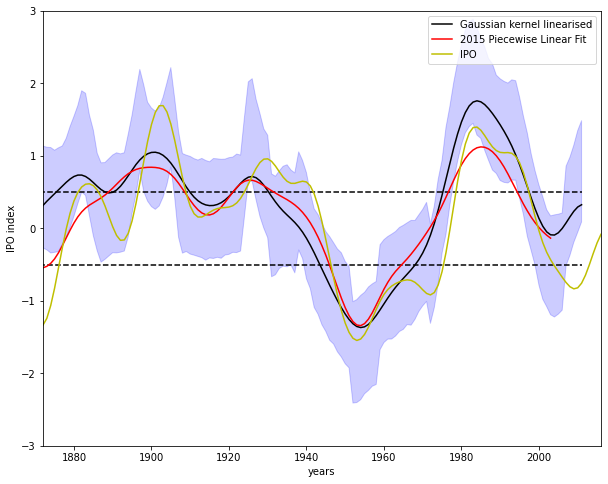

In [19]:
#Plot the instrumental period only

fig,ax=plt.subplots(1,1,figsize=[10,8])

ax.plot(gaussian_linearised[:,0],gaussian_filter(gaussian_linearised[:,1],3.9),  'k-',label='Gaussian kernel linearised')

ax.plot(old_reco[:,0],old_reco[:,1],'r' ,label='2015 Piecewise Linear Fit')
ax.hlines([-0.5, 0.5],-4,2011,colors='k',linestyles='dashed')
ax.plot(ipo_years,smooth_ipo,'y',label='IPO')

plt.fill_between(gaussian_linearised[:,0], gaussian_linearised[:,1]-gaussian_linearised[:,2], gaussian_linearised[:,1]+gaussian_linearised[:,2],
                 color='blue', alpha=0.2)
ax.set_xlim([1872,2016])
ax.set_ylim([-3,3])
ax.set_xlabel('years')
ax.set_ylabel('IPO index')
ax.legend()
plt.savefig('IPO_reconstruction_instrumental.png')

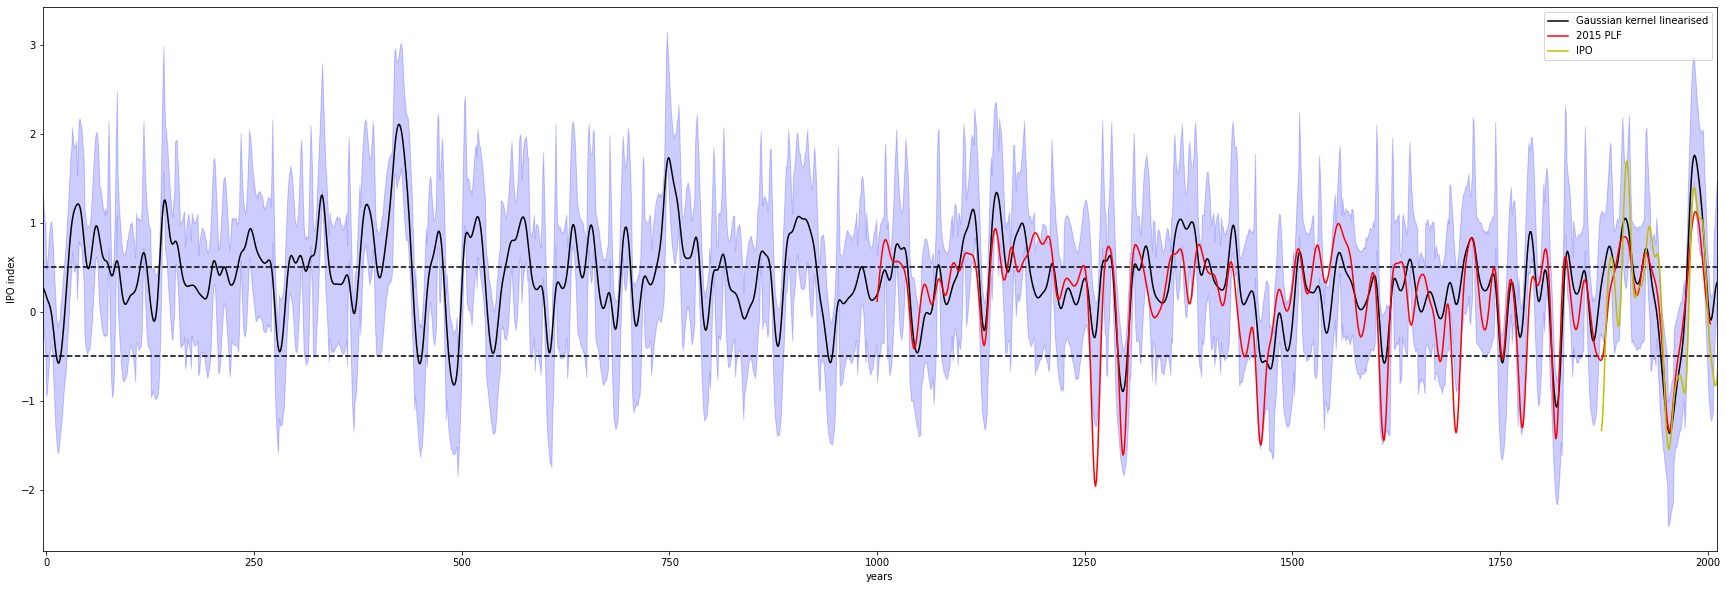

In [20]:

fig,ax=plt.subplots(1,1,figsize=[30,10])

ax.plot(gaussian_linearised[:,0],gaussian_filter(gaussian_linearised[:,1],3.9),  'k-',label='Gaussian kernel linearised')

ax.plot(old_reco[:,0],old_reco[:,1],'r' ,label='2015 PLF')
ax.hlines([-0.5, 0.5],-4,2011,colors='k',linestyles='dashed')
ax.plot(ipo_years,smooth_ipo,'y',label='IPO')
#plt.fill_between(output[:,0], output[:,1]-output[:,2], output[:,1]+output[:,2],color='gray', alpha=0.2)
plt.fill_between(gaussian_linearised[:,0], gaussian_linearised[:,1]-gaussian_linearised[:,2], gaussian_linearised[:,1]+gaussian_linearised[:,2],
                 color='blue', alpha=0.2)
ax.set_xlim([-4,2011])
ax.set_xlabel('years')
ax.set_ylabel('IPO index')
ax.legend()

plt.savefig('IPO_reocnstruction_2kyears.png')